In [17]:
from shared import graph, stats_utils
from src_draft.utils import LOW_IMP_FEATURES
import shared.ml_config_core as ml_config_core
import pandas as pd
from shared.ml_config_core import ModelConfigsCollection
from shared.ml_config_runner import run_tuning_for_configs_collection
from shared.definitions import TuningResult
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from pandas import CategoricalDtype
from Draft import feature_builder_v2

import importlib
from matplotlib import pyplot as plt
import src_draft.utils as shared_utils
import seaborn as sns

In [18]:
importlib.reload(shared_utils)

shared_utils.pandas_config(pd)
shared_utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

In [19]:
features_matrix = feature_builder_v2.load_datasets_and_prepare_features(drop_meta_data=True,
                                                                        ds_type=feature_builder_v2.DatasetType.FULL)


index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
Full DS size: 307511


In [20]:
conditions = [
    features_matrix["PrevRatioRejectedAccepted"].isna(),
    features_matrix["PrevRatioRejectedAccepted"] == 0,
    features_matrix["PrevRatioRejectedAccepted"] <= 0.25,
    features_matrix["PrevRatioRejectedAccepted"] > 0.25
]

conditions_2 = [
    features_matrix["PrevRatioRejectedAccepted"].isna(),
    features_matrix["PrevRatioRejectedAccepted"] == 0,
    features_matrix["PrevRatioRejectedAccepted"] > 0,
]


choices = ["No Previous App.", 'All Accepted', "< 25% Rejected", "> 25% Rejected"]
choices_2 = ["No Previous App.", 'All Accepted', "> 0% Rejected"]
# choices = ['All Accepted', "> 0 Rejected"]
# choices = ['No Previous', '0', '> 0']

features_matrix["PrevRatioRejectedAccepted_cats"] = np.select(conditions, choices, default='No Previous App')
features_matrix["PrevRatioRejectedAccepted_cats_2"] = np.select(conditions, choices, default='No Previous App')

features_matrix["PrevRatioRejectedAccepted_cats"] = features_matrix["PrevRatioRejectedAccepted_cats"].astype("category")
features_matrix["PrevRatioRejectedAccepted_cats_2"] = features_matrix["PrevRatioRejectedAccepted_cats_2"].astype("category")


In [21]:
stats_utils.nan_summary(features_matrix[["PrevRatioRejectedAccepted"]])

,Total NaN Values,Proportion NaN (%)
PrevRatioRejectedAccepted,16847,5.0


### Exploratory Analysis

This notebooks includes the analysis of selected variables (based on their importance at predicting the target variable) and their relationships. Individual analysis of each variable is available in the `EDA_appendices` notebook.

In [22]:
add_features = ["PrevRatioRejectedAccepted_cats", "PrevRatioRejectedAccepted_cats_2", "TARGET"]
features_matrix_only_high_imp = features_matrix[shared_utils.HIGH_IMP_FEATURES + add_features]
features_matrix_any_imp = features_matrix[shared_utils.ANY_IMP_FEATURES + add_features]


In [23]:
# TODO impute missing values, either 
stats_utils.nan_summary(features_matrix_only_high_imp)

,Total NaN Values,Proportion NaN (%)
ExtSource2,660,0.0
ExtSource3,60965,20.0
ExtSource1,173378,56.0
AmtGoodsPrice,278,0.0
OwnCarAge,202929,66.0
PrevAmtDownPaymentSum,16454,5.0
AmtAnnuity,12,0.0
MeanbureaudaysCredit,44020,14.0
MeanbureauamtCreditSumDebt,51380,17.0
PrevAvgYieldGroup,18945,6.0


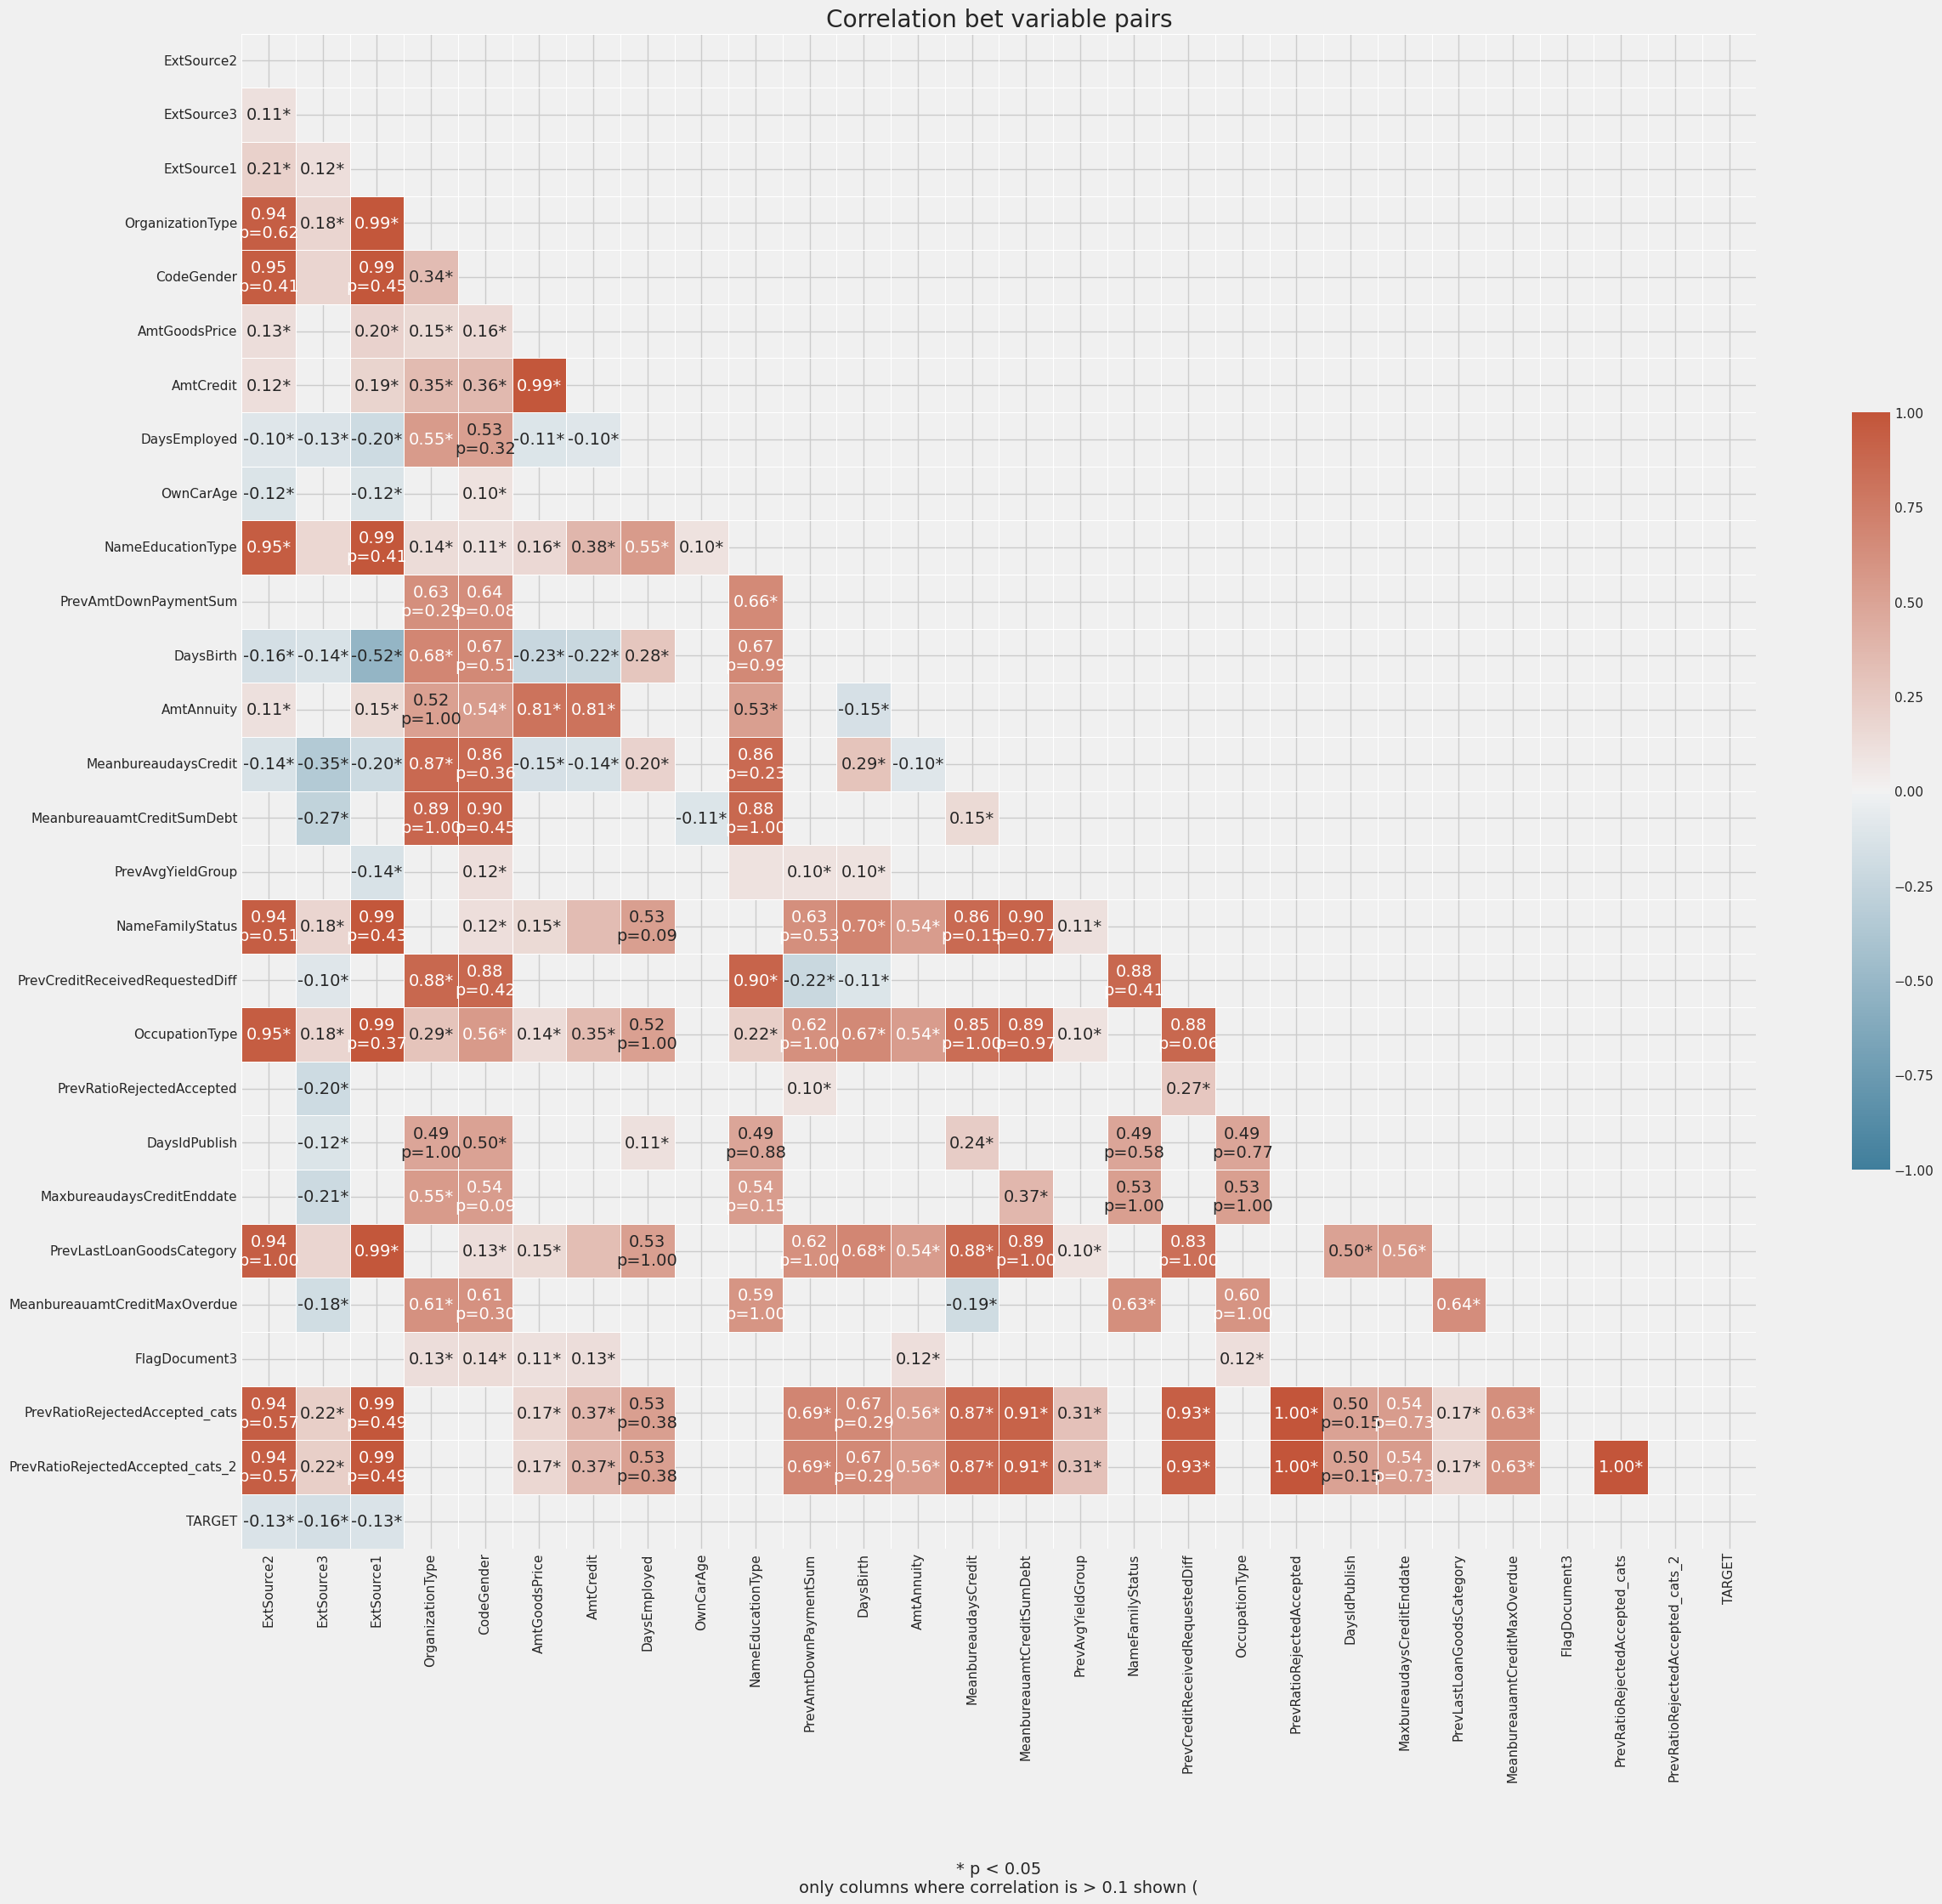

In [24]:
# TODO impute missing values (mean for numerical, proportion sampling for cat)
# OR inside correlation check just drop rows with missing values for tested columns
importlib.reload(graph)

features_matrix_any_imp_no_nan = features_matrix_only_high_imp.dropna(axis=0, how="any")
features_matrix_any_imp_no_nan = features_matrix_any_imp_no_nan.apply(
    lambda col: col.astype(float) if col.dtype == 'Float64' else col.astype(int) if col.dtype == 'Int64' else col)

graph.render_corr_matrix_based_on_type(features_matrix_any_imp_no_nan)

The `TARGET` variable (loans with payment difficulties) is most correlated with credit ratings obtained from external sources. The correlation is very weak but still significant.

In [25]:
correlation_results = []
for col in features_matrix_any_imp_no_nan.columns:
    if col == "TARGET":
        continue
    x = features_matrix_any_imp_no_nan["TARGET"]
    y = features_matrix_any_imp_no_nan[col]

    corr_value, p_value = stats_utils.correlation_test(x, y)
    
    if p_value < 0.05:
        correlation_results.append({'Column': col, 'Coefficient': corr_value, 'P-Value': p_value})

correlation_df = pd.DataFrame(correlation_results).set_index('Column')
correlation_df = correlation_df.loc[correlation_df['Coefficient'].abs().sort_values(ascending=False).index]
correlation_df.round(3)


,Coefficient,P-Value
Column,,
ExtSource3,-0.161,0.000
ExtSource1,-0.131,0.000
ExtSource2,-0.128,0.000
MeanbureaudaysCredit,0.093,0.000
OccupationType,0.075,0.000
DaysEmployed,0.074,0.000
PrevRatioRejectedAccepted,0.073,0.000
PrevRatioRejectedAccepted_cats,0.072,0.000
PrevRatioRejectedAccepted_cats_2,0.072,0.000


``
Because the datatypes of features vary we had to use different methods to measure the strength and significance of each pair:

- Chi-Squared Test: Assesses independence between two categorical variables.  For bool-bool pairs due to categorical nature.

- Point Biserial Correlation: Measures correlation between a binary and a continuous variable. For bool-numerical pairs to account for mixed data types.

- Spearman's Rank Correlation: Assesses monotonic relationship between two continuous variables. Used for numerical-numerical pairs (for non-normally distributed data).

Since the Chi-Squared test outputs an unbound statistic/value which can't be directly compared to  pointbiserialr or Spearman Rank we have converted them to a  ` Cramér's V:` value which is normalized between 0 and 1. This was done to make the values in the matrix more uniform however we must note that Cramér's V and Spearman's correlation coefficients are fundamentally different statistics and generally can't be directly compared.
```

In [26]:
features_matrix_only_imp_cat_cols = features_matrix_only_high_imp.select_dtypes(include='category').columns
features_matrix_target_cat = features_matrix_only_high_imp.copy()
features_matrix_target_cat["TARGET"] = features_matrix_target_cat["TARGET"].map(
    lambda x: "Default/Loan With Issues" if x == 1 else "No Issues")

In [27]:
features_matrix_target_cat["PrevRatioRejectedAccepted_cats"].dtype

CategoricalDtype(categories=['< 25% Rejected', '> 25% Rejected', 'All Accepted', 'No Previous App.'], ordered=False)

The chart below shows the relationship between selected categorical variables and loan status. E.g. a significantly higher proportion of loans taken out by males had issues.

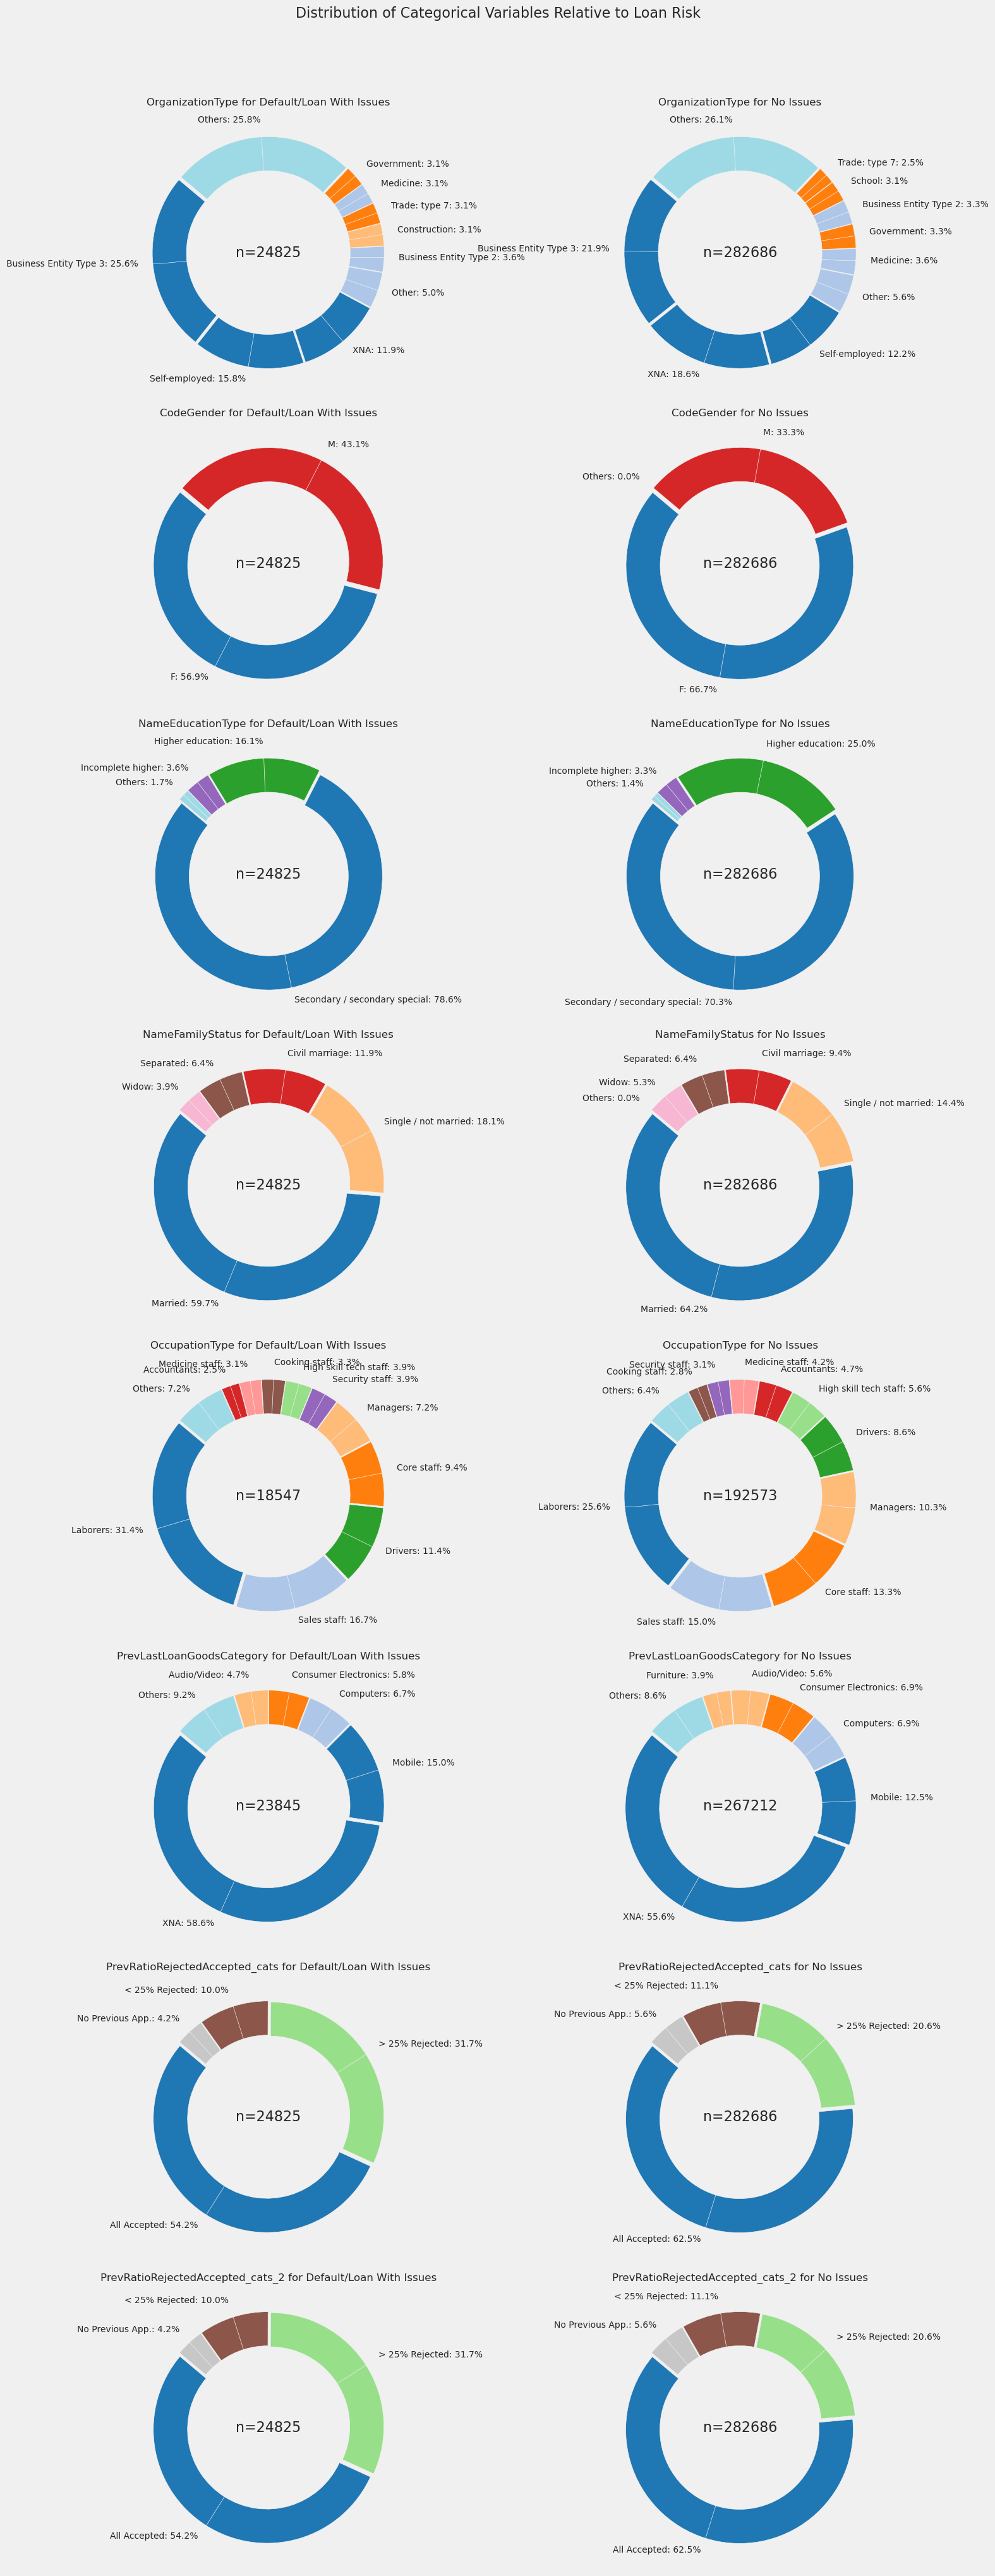

In [28]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_target_cat,
    split_var="TARGET",
    include_cols=features_matrix_only_imp_cat_cols,
    title="Distribution of Categorical Variables Relative to Loan Risk",
    clean_tick_label = False,
)

In [29]:
features_matrix_with_bins = features_matrix_only_high_imp.copy()
numerical_cols = features_matrix_only_high_imp.select_dtypes(
    include=["int64", "float64", "Int64"]
).columns

for col in numerical_cols:
    if features_matrix_with_bins[col].nunique() < 5:
        features_matrix_with_bins[f"{col}_binned"] = features_matrix_with_bins[col].astype("category")
    else:
        features_matrix_with_bins[f"{col}_binned"] = stats_utils.bin_and_label(
            features_matrix_with_bins[col], num_bins=4
        )
    features_matrix_with_bins[col] = features_matrix_with_bins[col]
import numpy as np


conditions = [
    features_matrix["TotalDefaults"] == 0,
    features_matrix["TotalDefaults"] >= 1,
    # features_matrix["TotalDefaults"] > 1
]

choices = ["No Defaults", '1 Defaulted Loans']  #,"> 1 defaulted loan"]
# choices = ['All Accepted', "> 0 Rejected"]
# choices = ['No Previous', '0', '> 0']

features_matrix_with_bins["TotalDefaults_cats"] = np.select(conditions, choices, default='WTF?').astype("object")

features_matrix_with_bins["Defaulted"] = features_matrix_with_bins["TARGET"].map(lambda x: "Yes" if x == 1 else "No")
features_matrix_with_bins.drop(columns=["TARGET", "TARGET_binned"], inplace=True)

In [30]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].dtype

CategoricalDtype(categories=['< 25% Rejected', '> 25% Rejected', 'All Accepted', 'No Previous App.'], ordered=False)

#### Relationships Between Numerical and Categorical Variables

The charts below show pairs of numerical and categorical features (including some binned numerical features) that have a signficant relationships and at least a small effect size (`eta_squared`>0.01) based on the non-parametric Kruskal-Wallis Test (one-way ANOVA on ranks)   testing whether samples originate from the same distribution.

*`It's similar to the Mann–Whitney U test but allows comparing more than 2 groups`

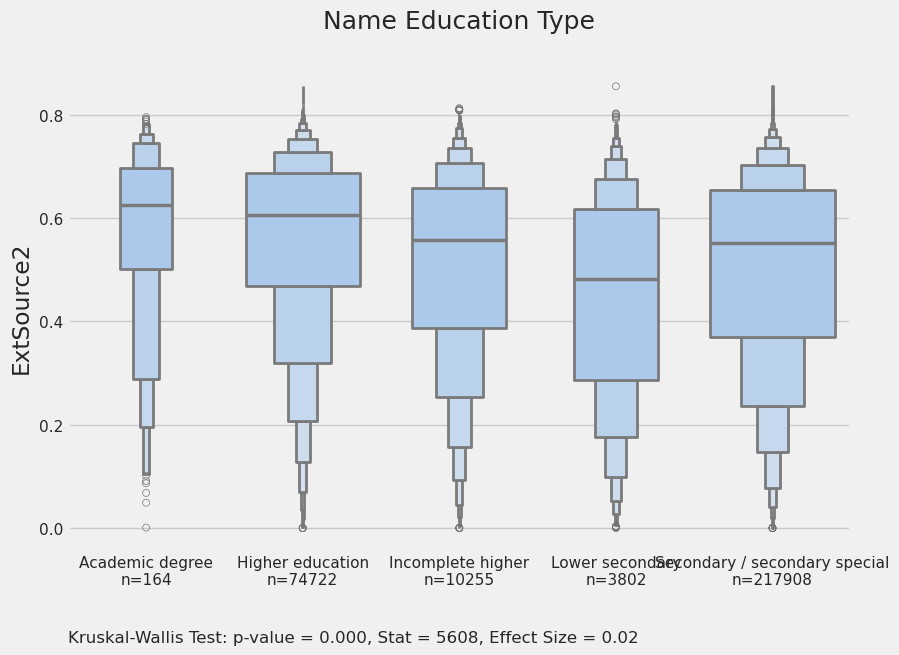

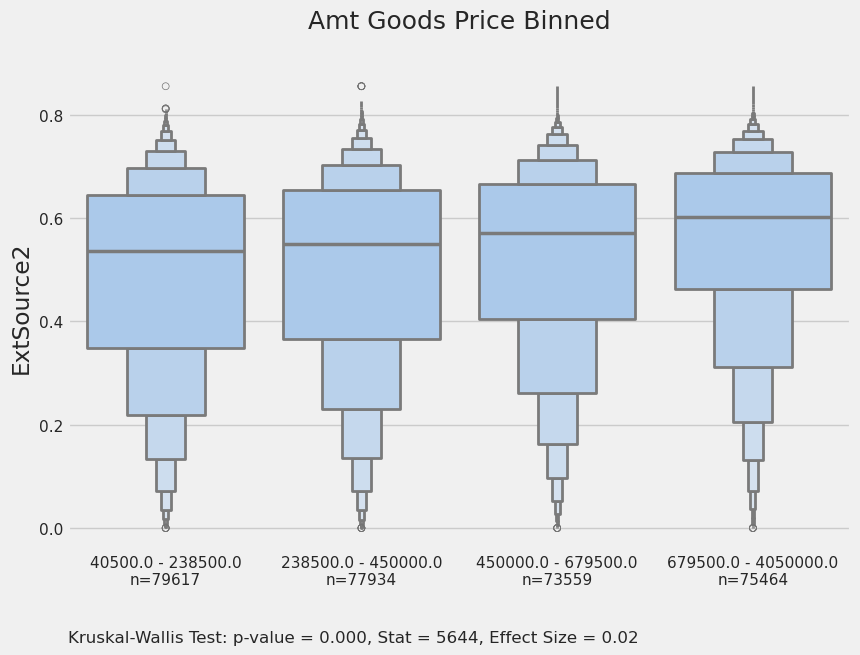

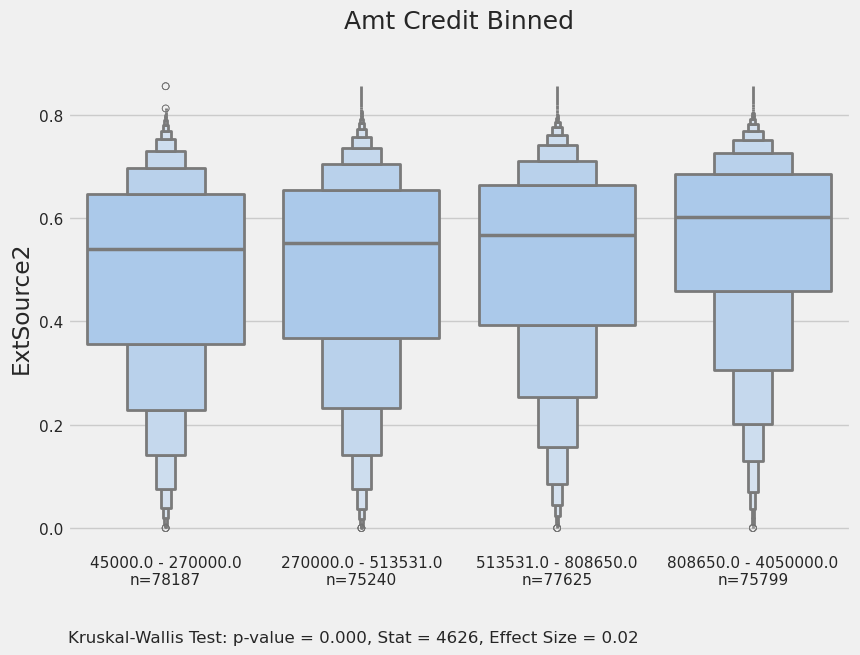

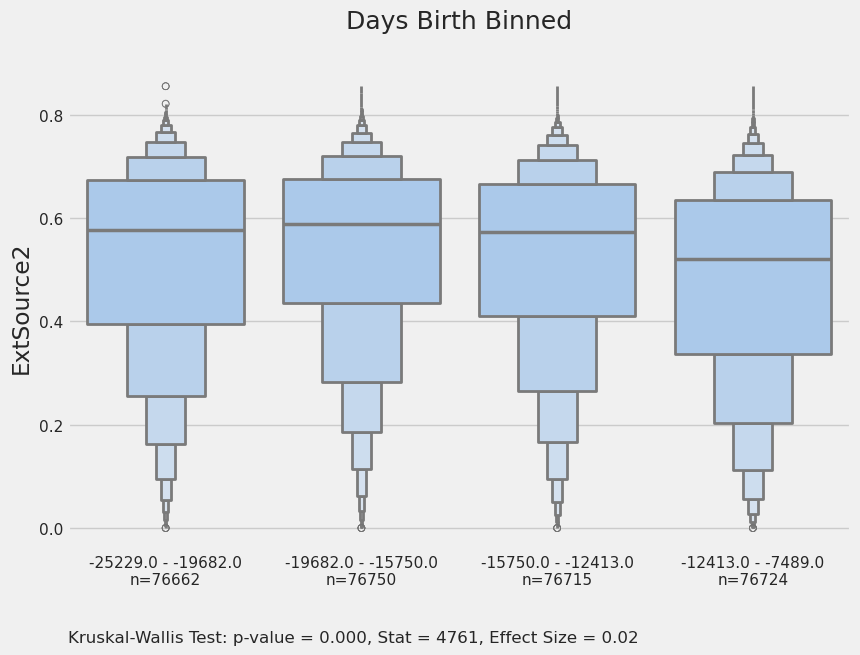

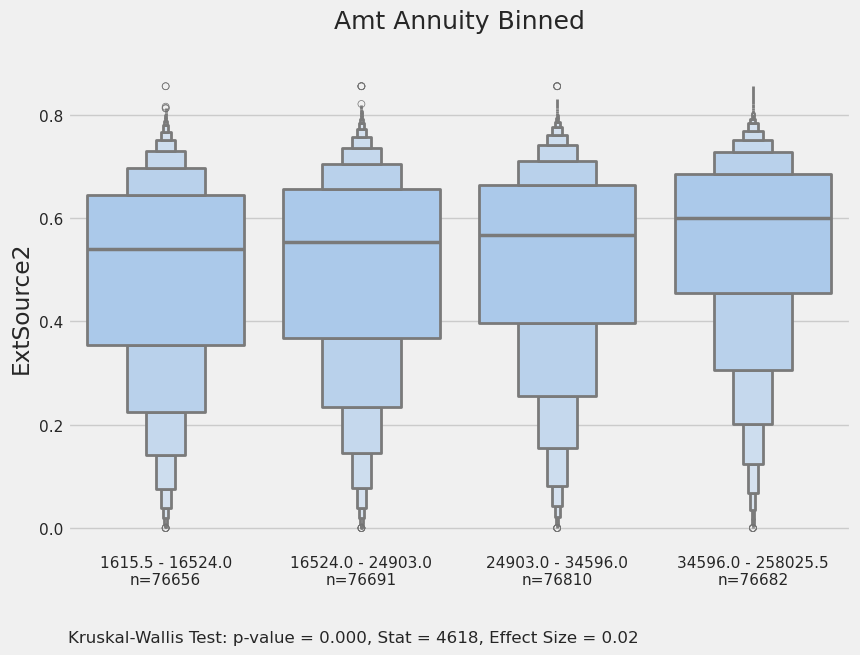

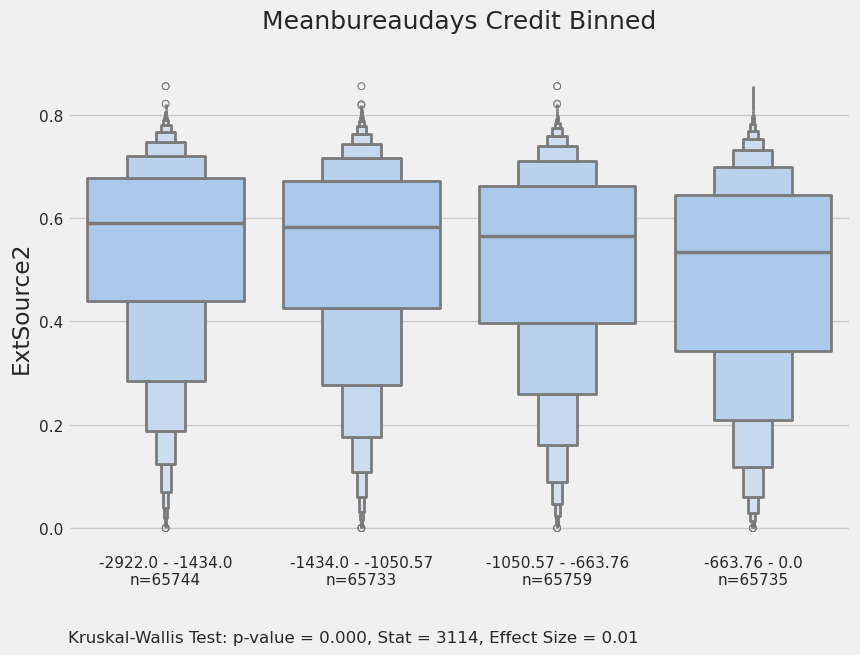

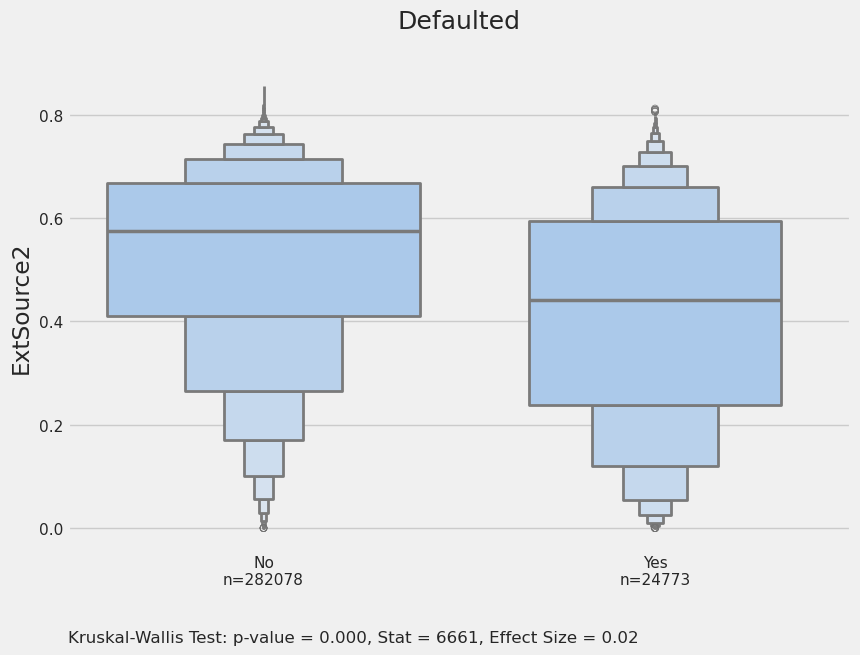

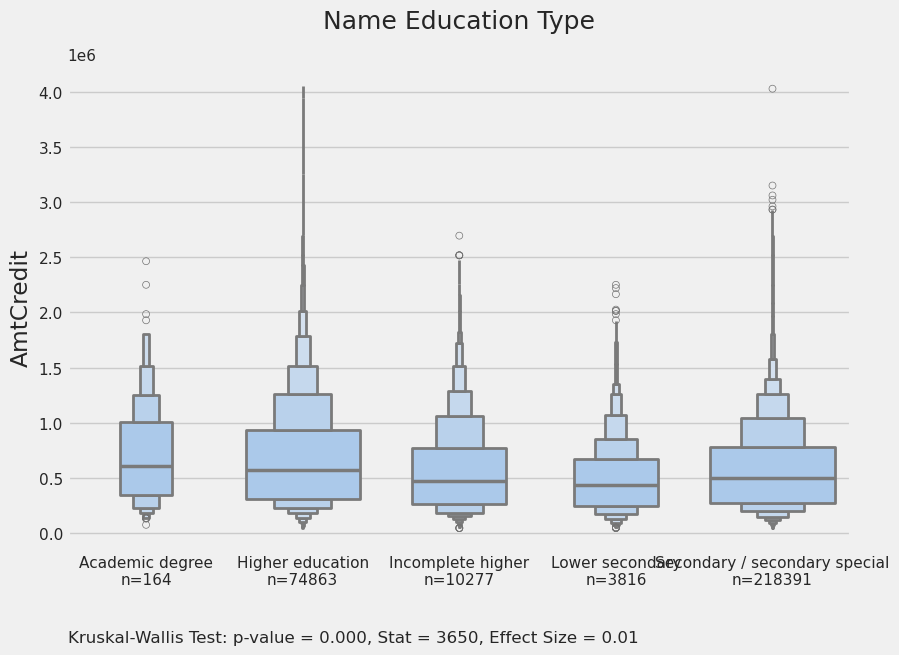

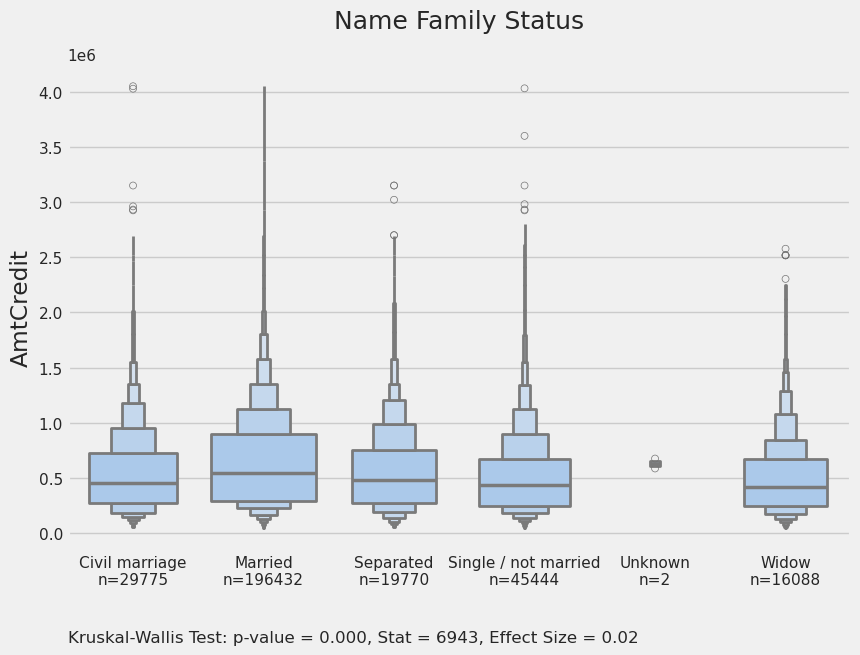

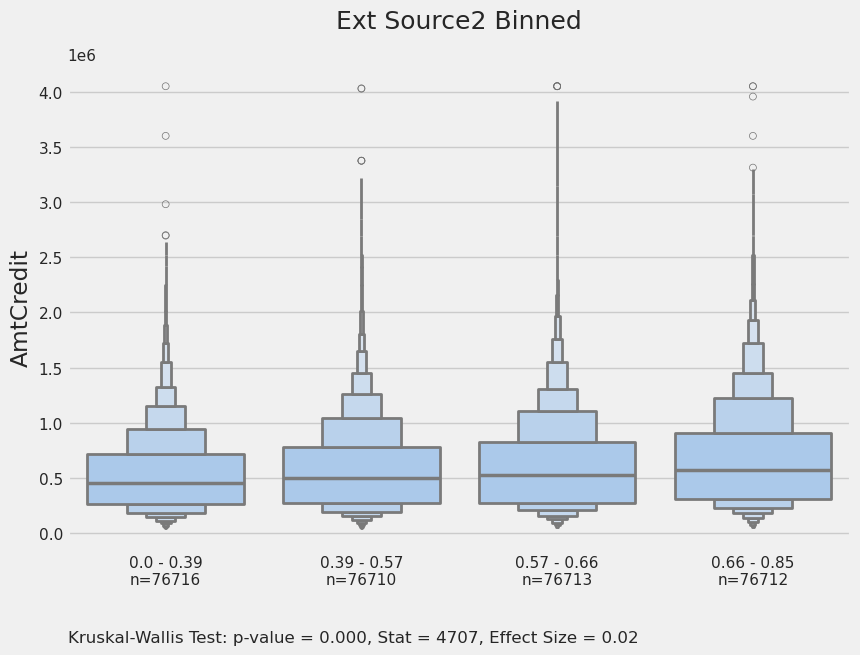

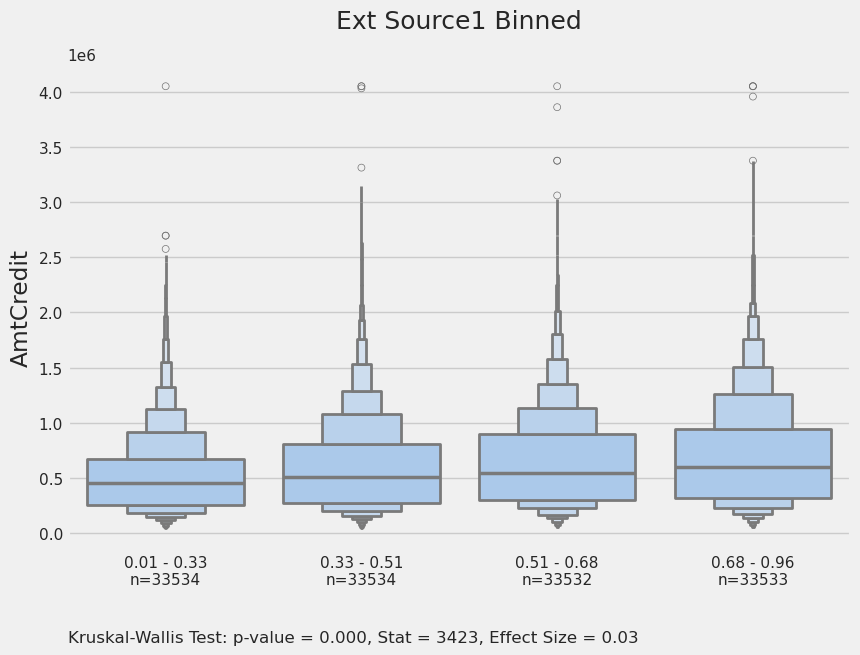

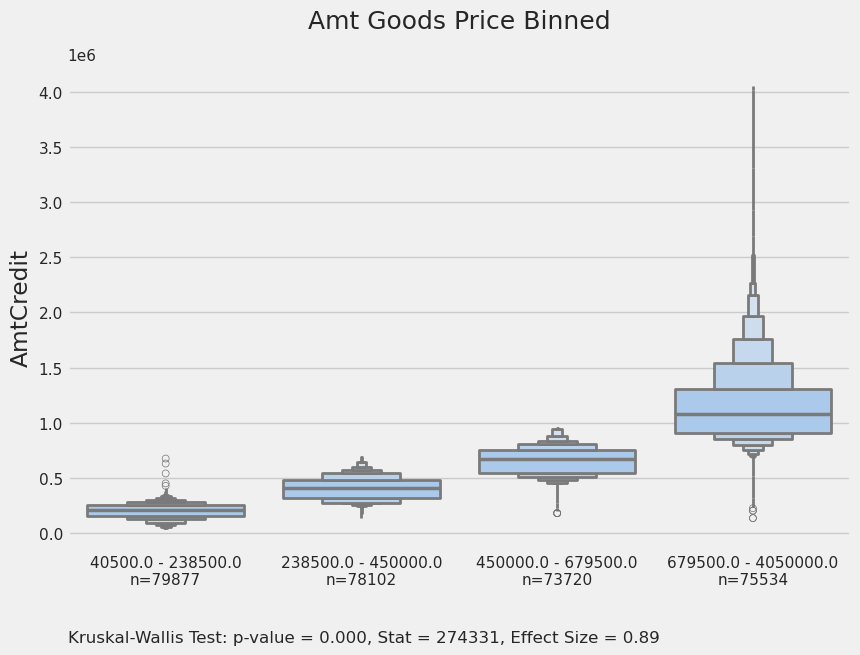

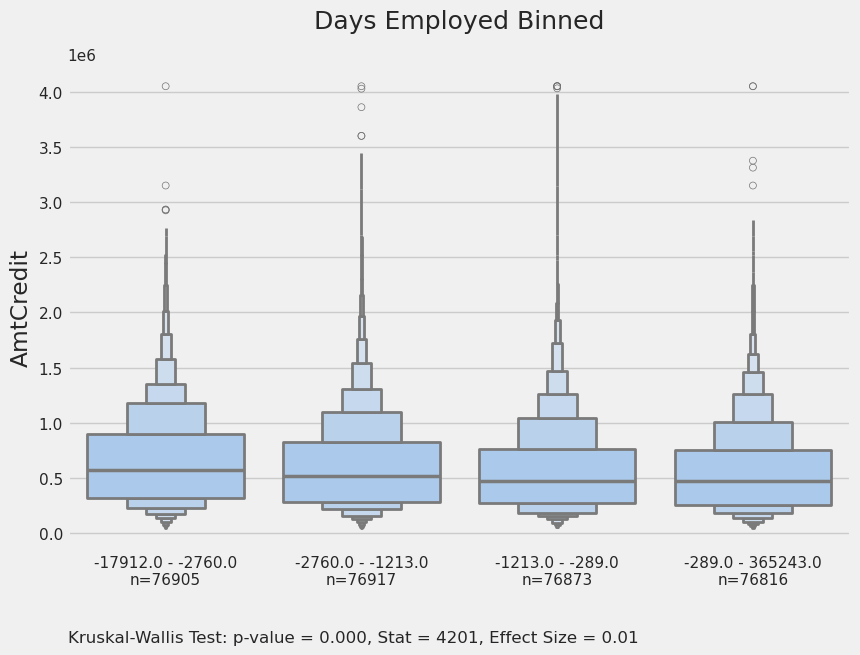

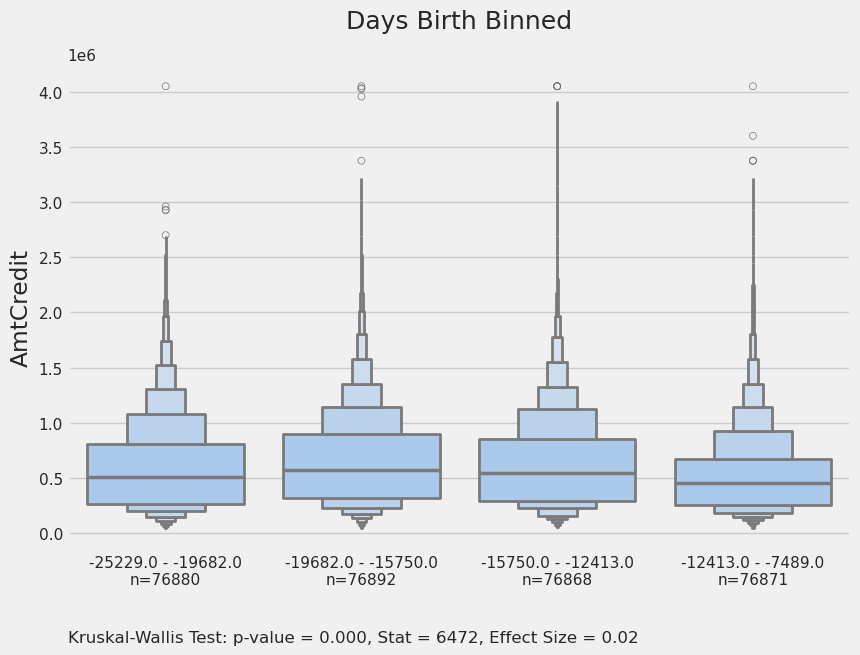

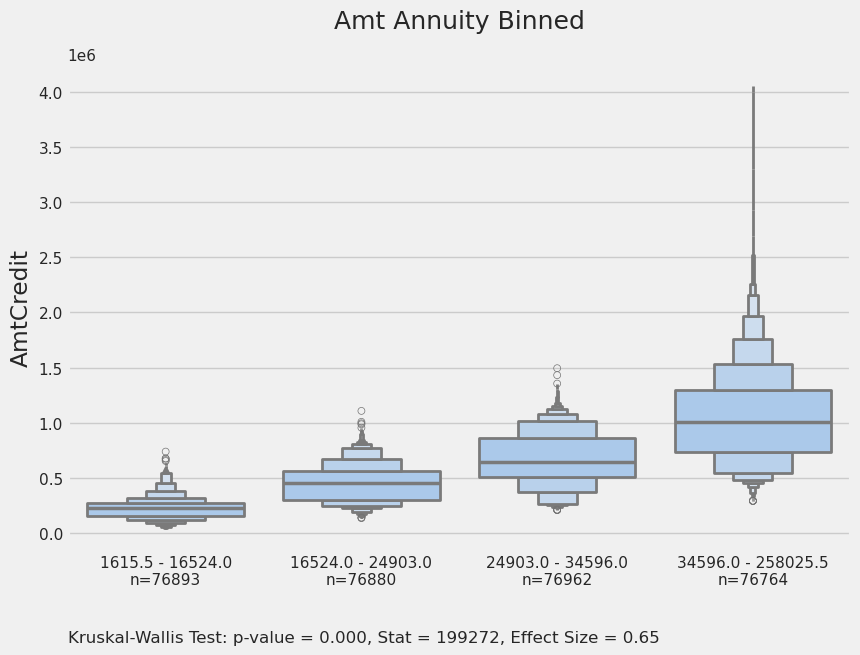

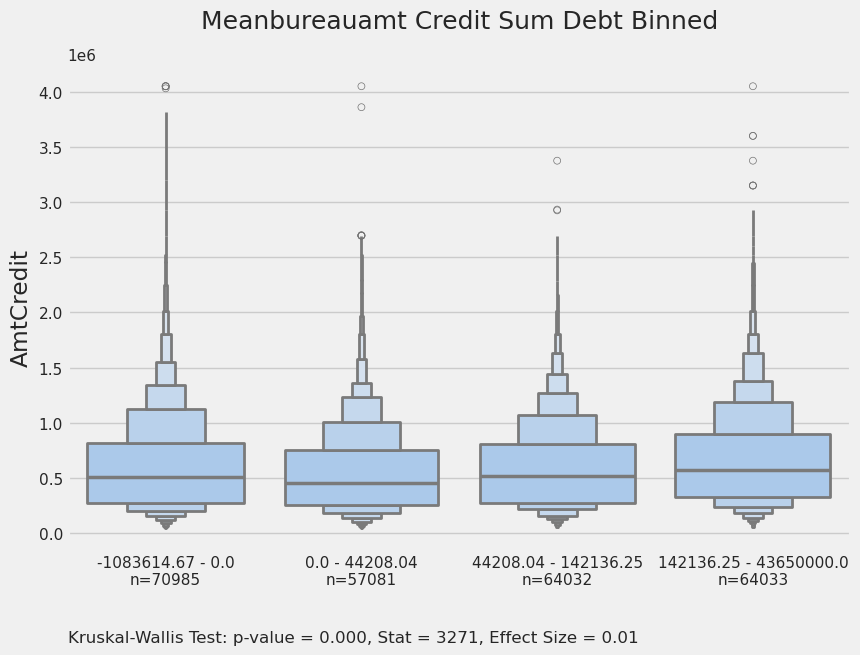

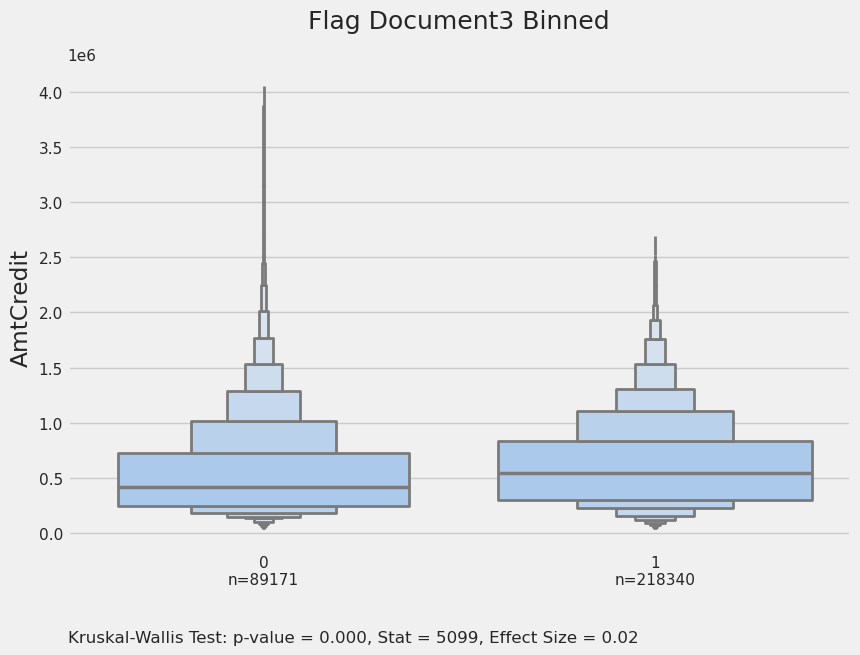

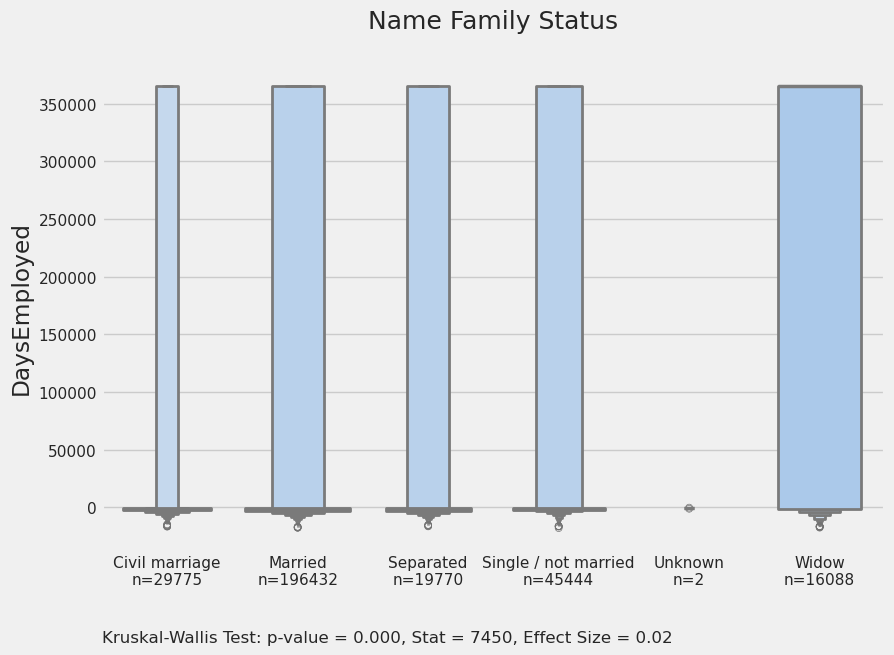

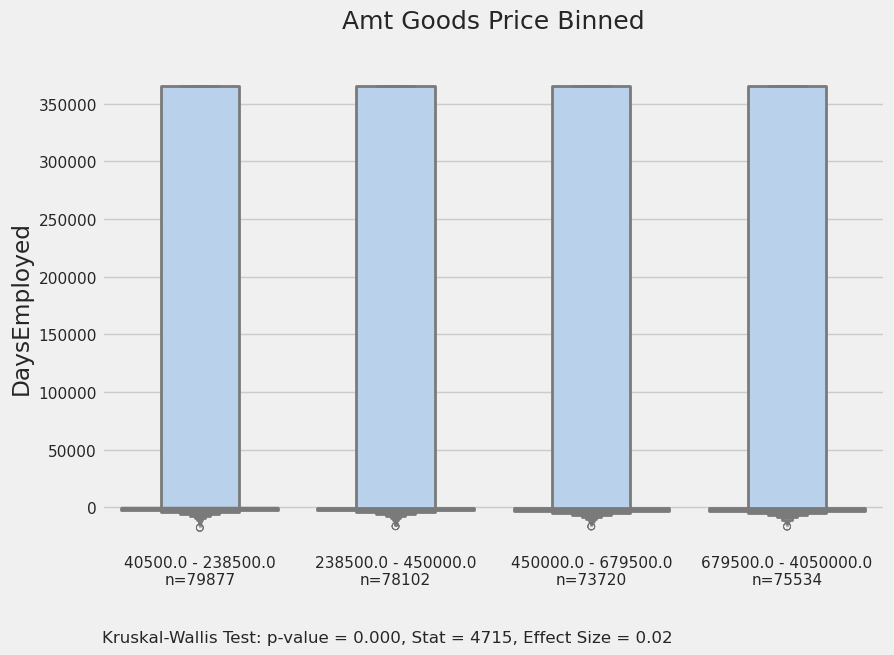

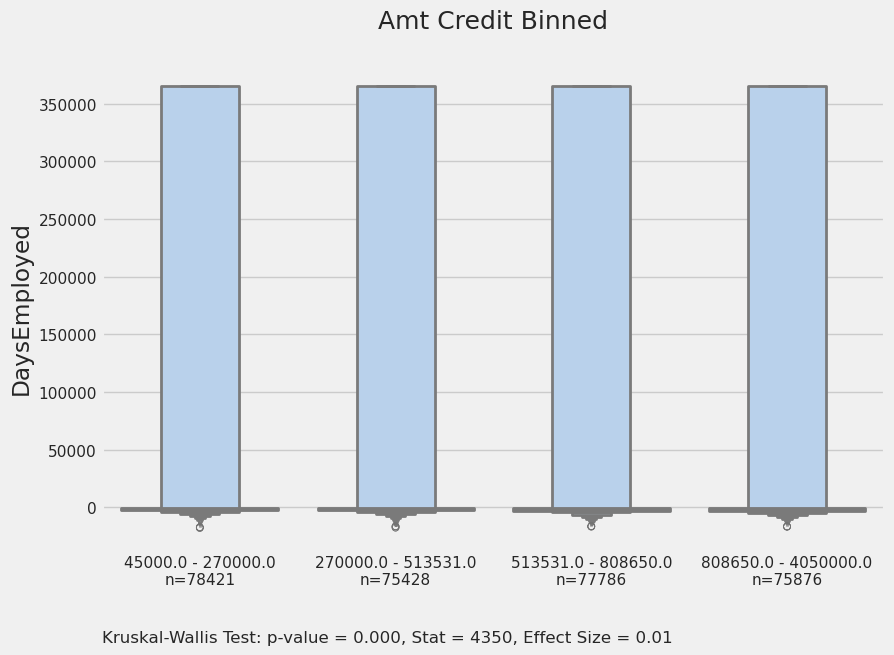

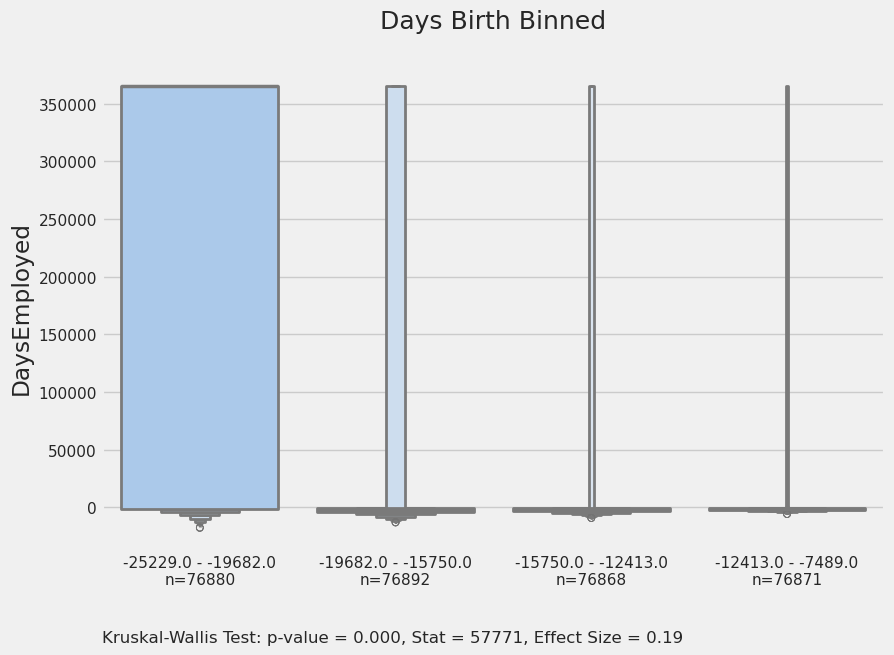

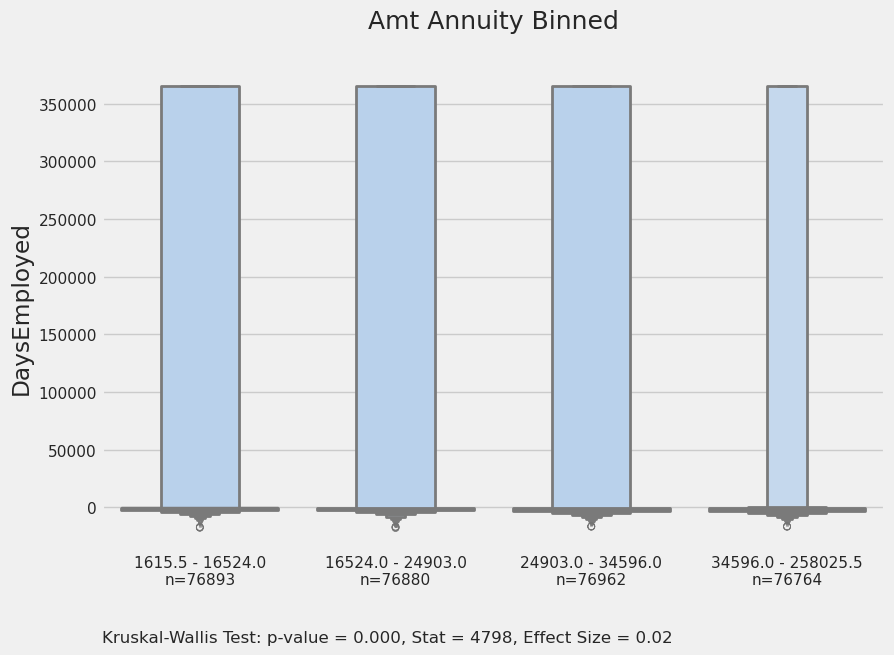

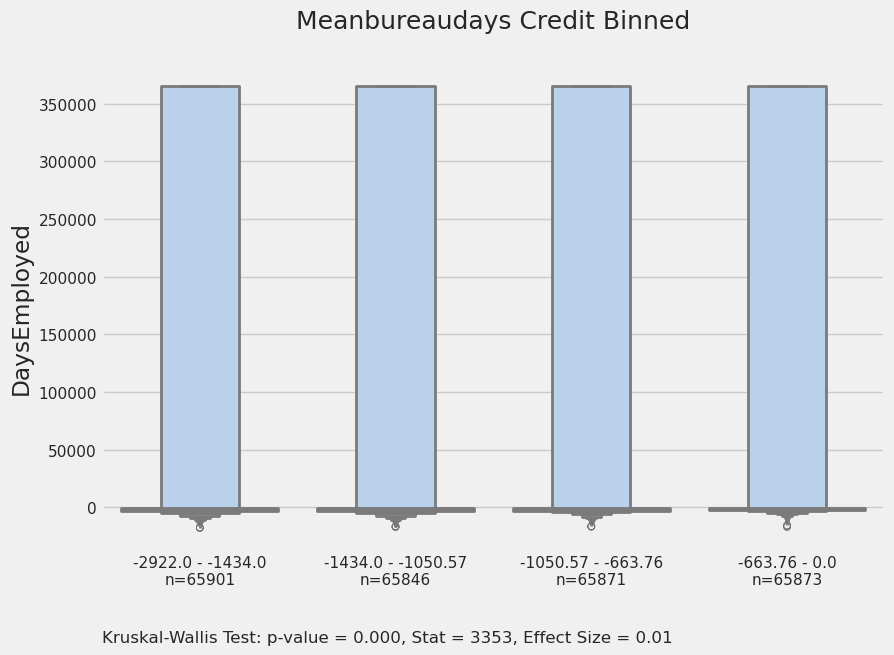

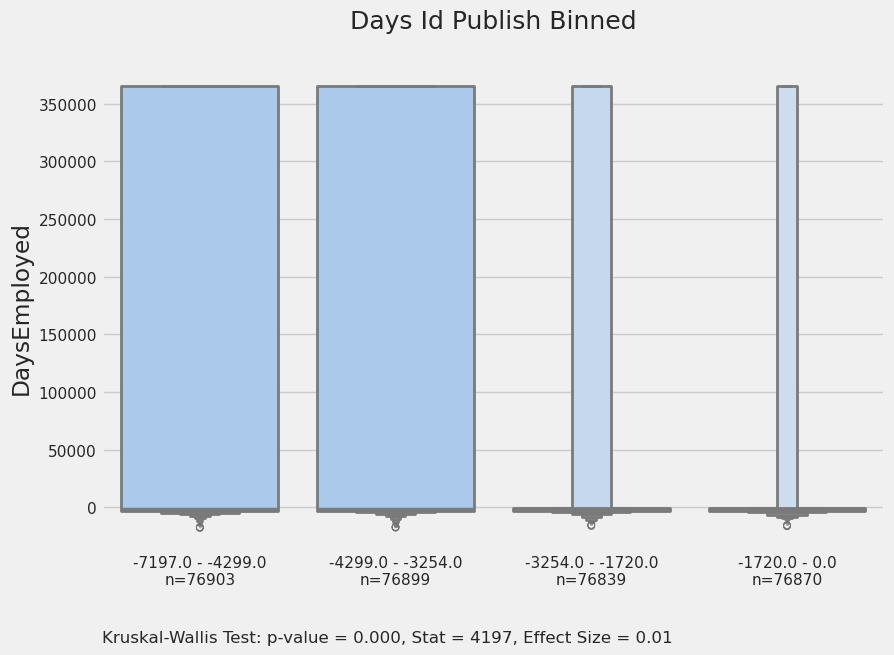

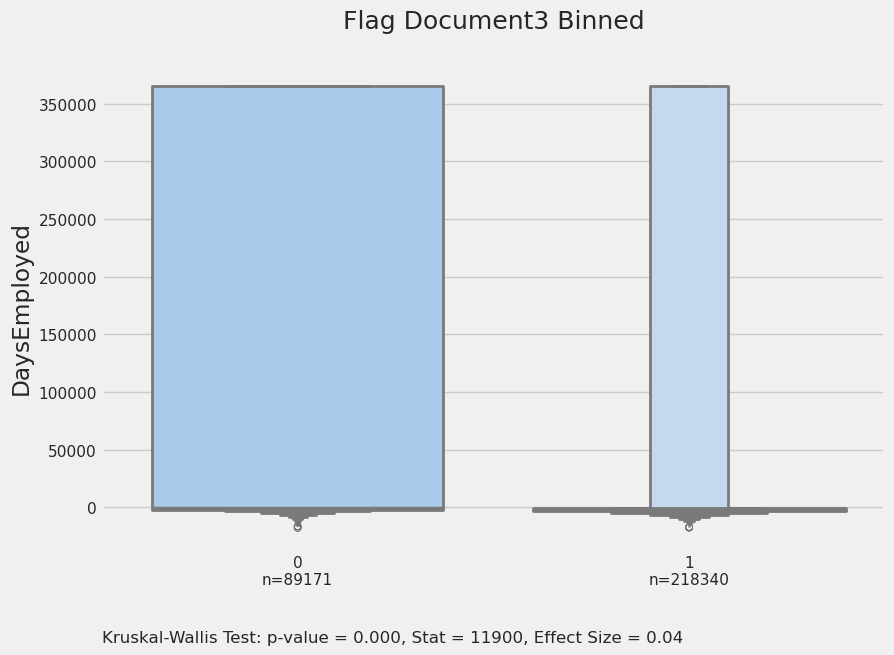

In [31]:
importlib.reload(graph)
for target_y in ["ExtSource2", "AmtCredit", "DaysEmployed"]:
    for c in features_matrix_with_bins.columns:
        if pd.api.types.is_numeric_dtype(features_matrix_with_bins[c]):
            continue

        if target_y in c and "binned" in c:
            continue
            
        if "ExtSource" in target_y and "ExtSource" in c:
            continue
            
        # Drop cols with to many categories
        if features_matrix_with_bins[c].nunique() > 10:
            continue
        # if VERBOSE:
        #     display(f"{c} vs {target_y}")
        res = graph.boxen_plot_by_cat(c, features_matrix_with_bins, target_y)
        
        if res:
            display(res)

#### External Credit Scores (`ExtSource1`)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


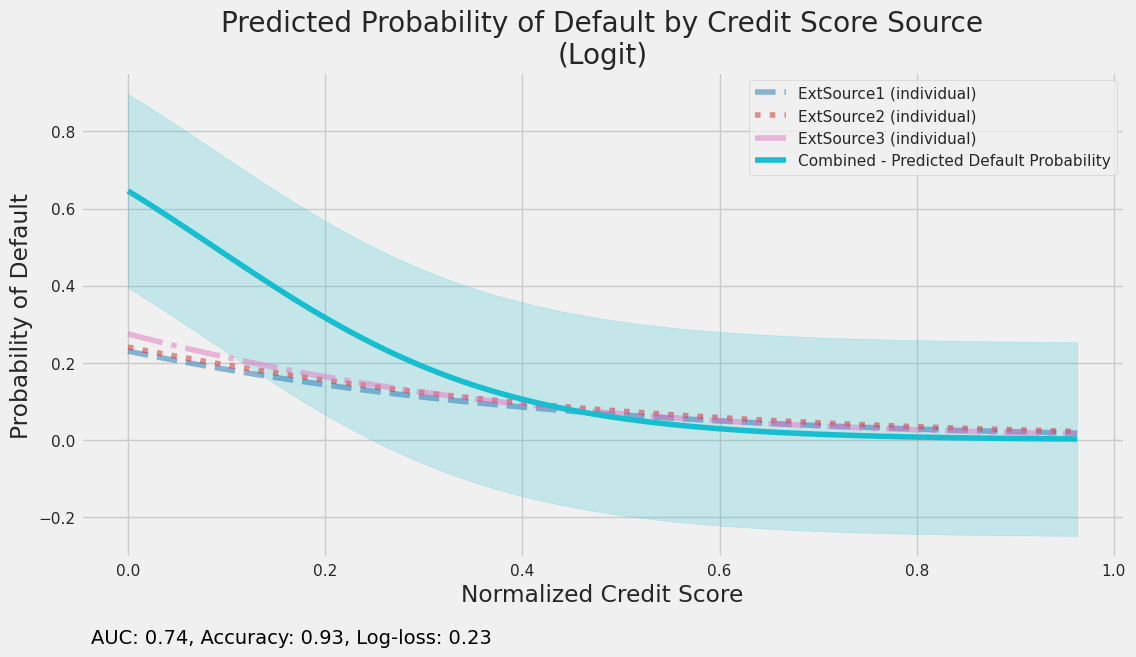

In [32]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

# Plot setup
plt.figure(figsize=(12, 6))

line_styles = ['--', ':', '-.']

x_range = np.linspace(features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3']].min().min(),
                      features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3']].max().max(), 100)

# Initialize lists for storing predictions
predictions = {}

colors = plt.cm.get_cmap('tab10', 4)

for i, source in enumerate(['ExtSource1', 'ExtSource2', 'ExtSource3']):
    subset = features_matrix[[source, 'TARGET']].dropna()
    X = sm.add_constant(subset[source])
    y = subset['TARGET']

    model = sm.Logit(y, X).fit(disp=0)
    X_pred = pd.DataFrame({'const': 1, source: x_range})

    y_pred = model.predict(X_pred)
    predictions[source] = y_pred

    plt.plot(x_range, y_pred, color=colors(i), linestyle=line_styles[i], alpha=0.5, label=f'{source} (individual)')

combined_features = features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3', 'TARGET']].dropna()
X_combined = sm.add_constant(combined_features[['ExtSource1', 'ExtSource2', 'ExtSource3']])
y_combined = combined_features['TARGET']

model_combined = sm.Logit(y_combined, X_combined).fit(disp=0)
X_pred_combined = pd.DataFrame({'const': 1, 'ExtSource1': x_range, 'ExtSource2': x_range, 'ExtSource3': x_range})

y_pred_combined = model_combined.predict(X_pred_combined)
y_pred_combined_for_metrics = model_combined.predict(X_combined)

predictions['Combined'] = y_pred_combined

residuals_combined = y_combined - model_combined.predict(X_combined)
residual_std_combined = np.std(residuals_combined)

combined_color = colors(3)  # Selecting the fourth color for the combined model
plt.plot(x_range, y_pred_combined, color=combined_color,
         label='Combined - Predicted Default Probability')  # Solid line for combined model
plt.fill_between(x_range, y_pred_combined - residual_std_combined, y_pred_combined + residual_std_combined,
                 color=combined_color, alpha=0.2)

auc_combined = roc_auc_score(y_combined, y_pred_combined_for_metrics)
accuracy_combined = accuracy_score(y_combined, y_pred_combined_for_metrics.round())  # Assuming binary classification
logloss_combined = log_loss(y_combined, y_pred_combined_for_metrics)

metrics = f"AUC: {auc_combined:.2f}, Accuracy: {accuracy_combined:.2f}, Log-loss: {logloss_combined:.2f}"
plt.annotate(metrics, xy=(0.01, -0.175), xycoords='axes fraction', fontsize=14, color='black')

plt.title('Predicted Probability of Default by Credit Score Source\n(Logit)')
plt.xlabel('Normalized Credit Score')
plt.ylabel('Probability of Default')
plt.legend()
plt.show()


In [33]:
model_params = model_combined.params
p_values = model_combined.pvalues
conf_int = model_combined.conf_int()
std_errors = model_combined.bse

coeff_df = pd.DataFrame({
    'Coefficient': model_params,
    'Standard Error': std_errors,
    'P-Value': p_values,
    'Conf. Interval Lower': conf_int[0],
    'Conf. Interval Upper': conf_int[1]
})
coeff_df.round(3)

,Coefficient,Standard Error,P-Value,Conf. Interval Lower,Conf. Interval Upper
const,0.600,0.040,0.0,0.521,0.680
ExtSource1,-2.099,0.061,0.0,-2.219,-1.979
ExtSource2,-1.964,0.060,0.0,-2.082,-1.846
ExtSource3,-2.779,0.062,0.0,-2.902,-2.657


Normalized credit ratings from three sources are inversely related to default risk, with `ExtSource3` having the strongest influence. We can see that a basic Logistic model can already provide a reasonably high result (AUC = 0.74). However, we have to note that the results are based on the full training set and are only provided for EDA/feature analysis purposes. Full statistical modelling will be done in further sections.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



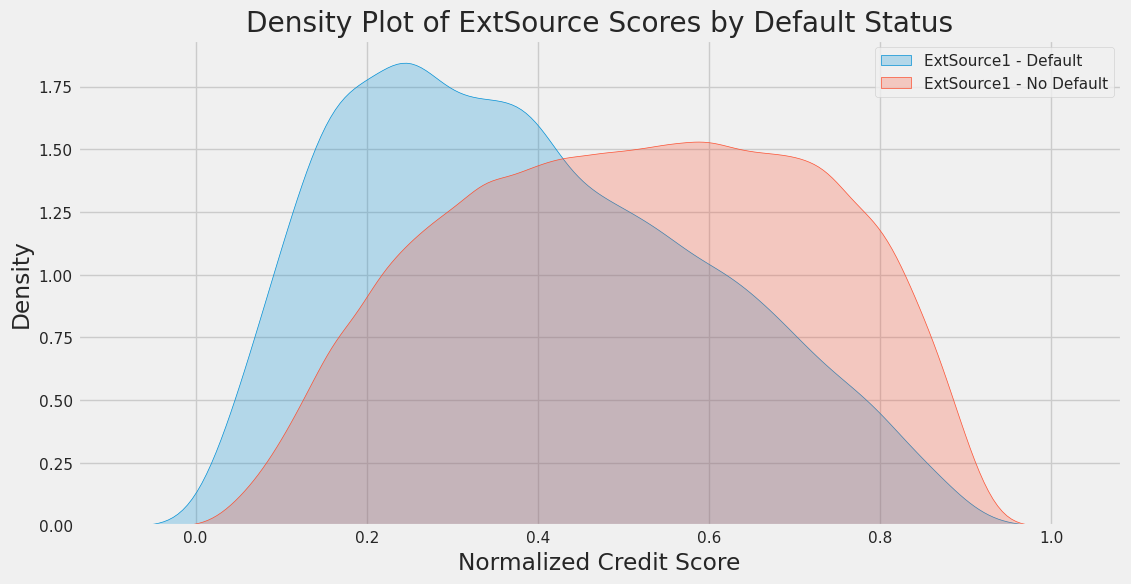

In [34]:
# Plotting
plt.figure(figsize=(12, 6))
for i in range(1, 2):
    col = f'ExtSource{i}'
    sns.kdeplot(data=features_matrix[features_matrix['TARGET'] == 1][col], label=f'{col} - Default', shade=True)
    sns.kdeplot(data=features_matrix[features_matrix['TARGET'] == 0][col], label=f'{col} - No Default', shade=True)

plt.title('Density Plot of ExtSource Scores by Default Status')
plt.xlabel('Normalized Credit Score')
plt.ylabel('Density')
plt.legend()
plt.show()


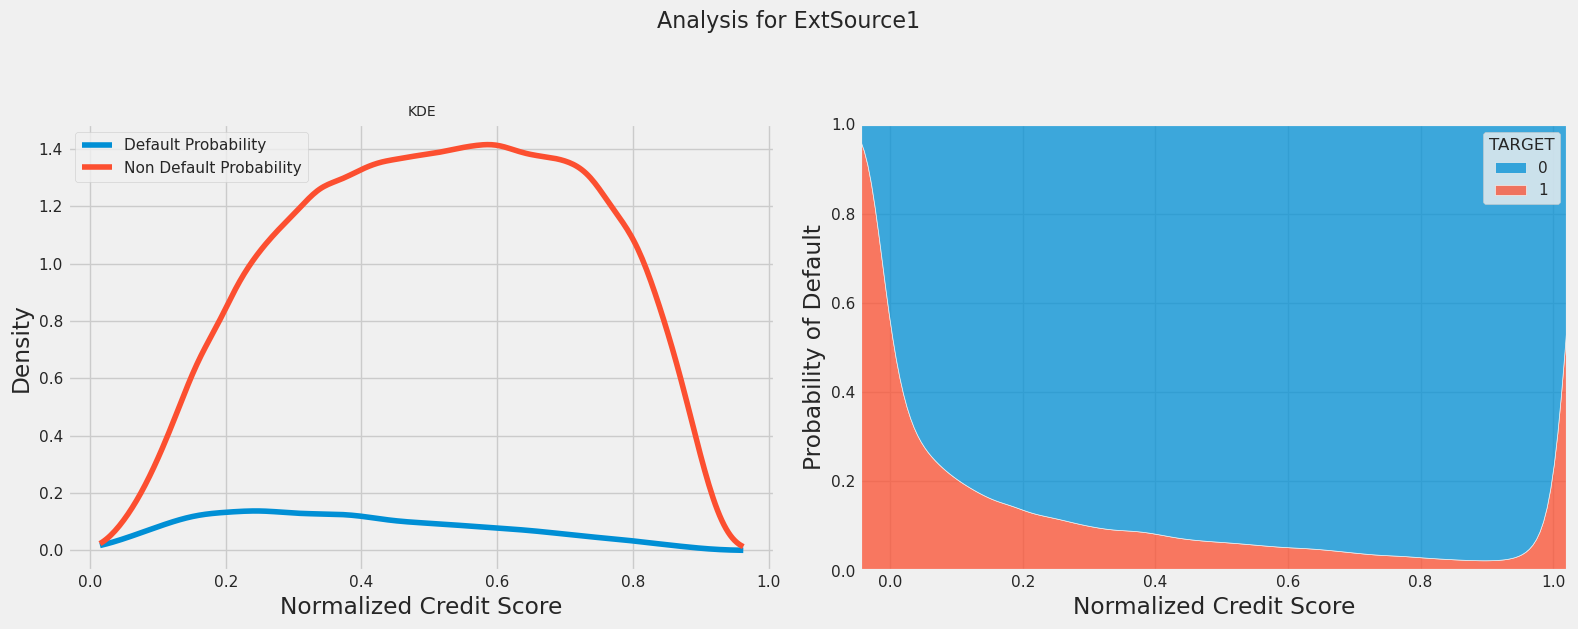

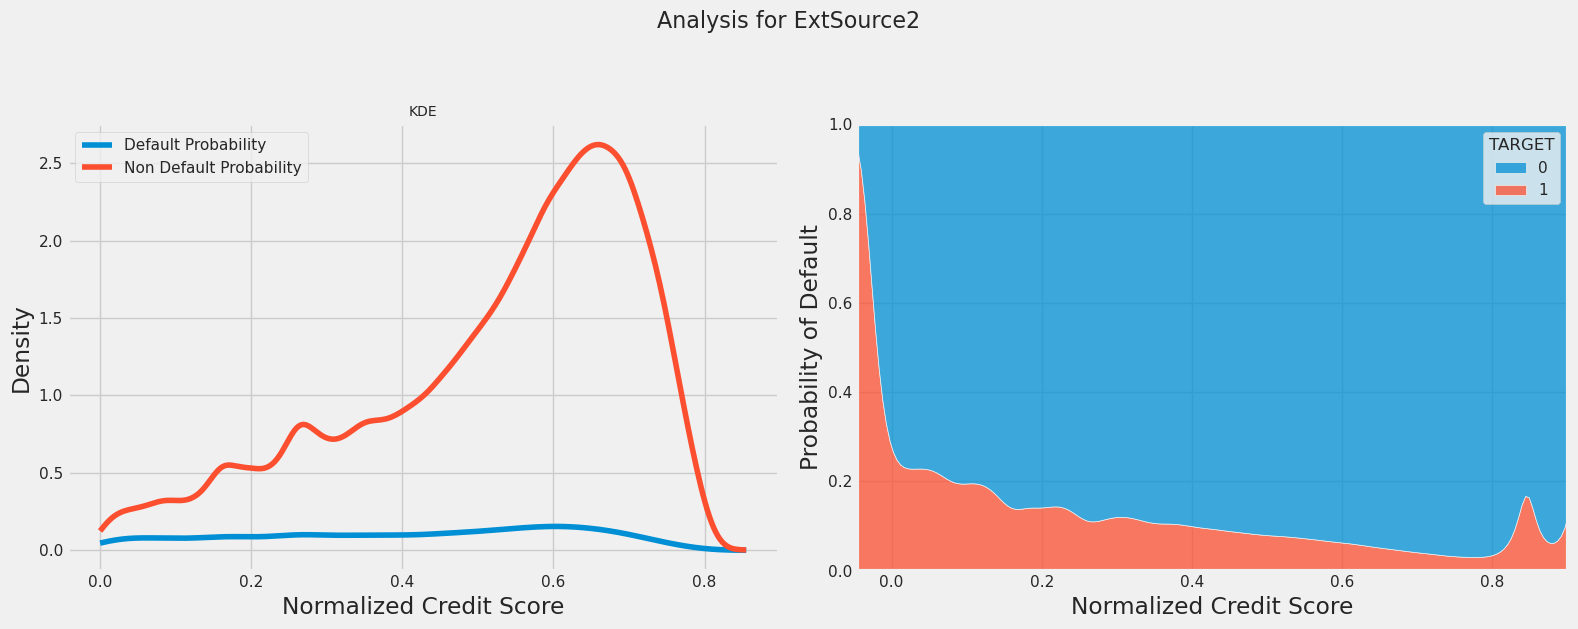

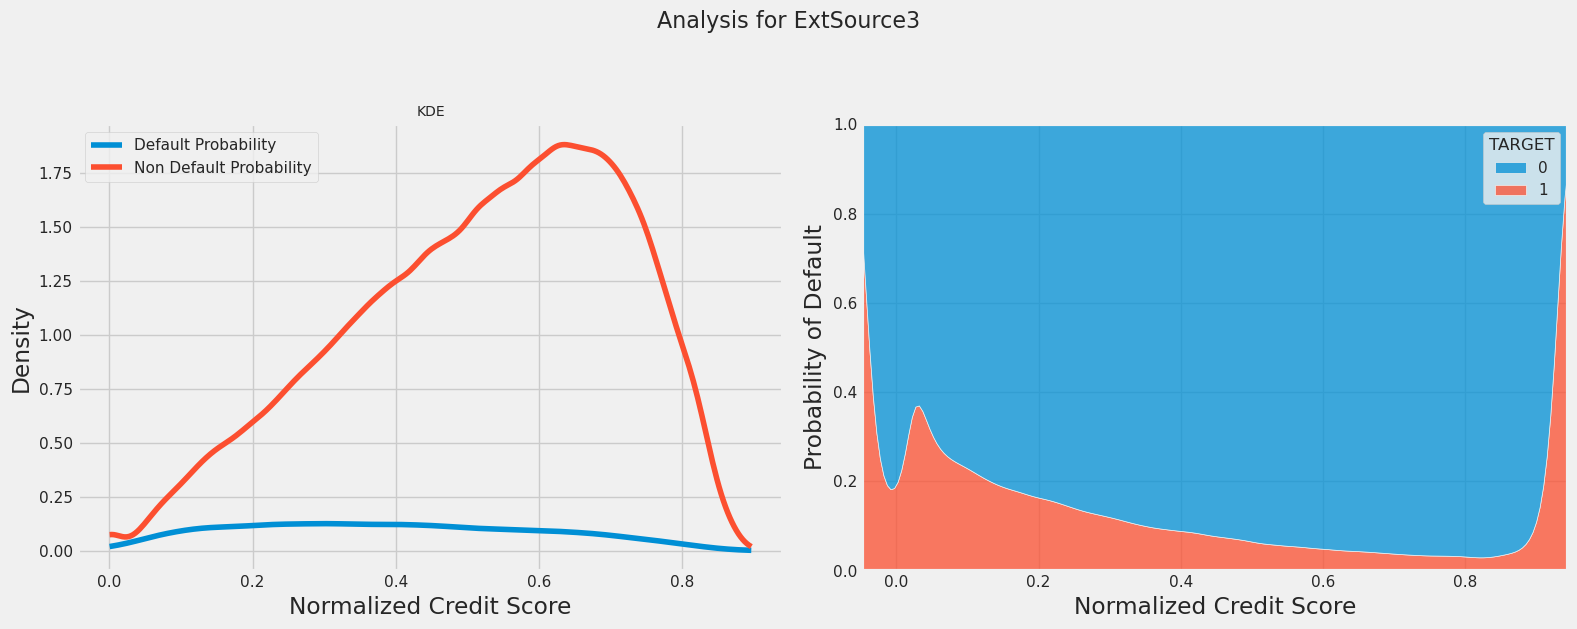

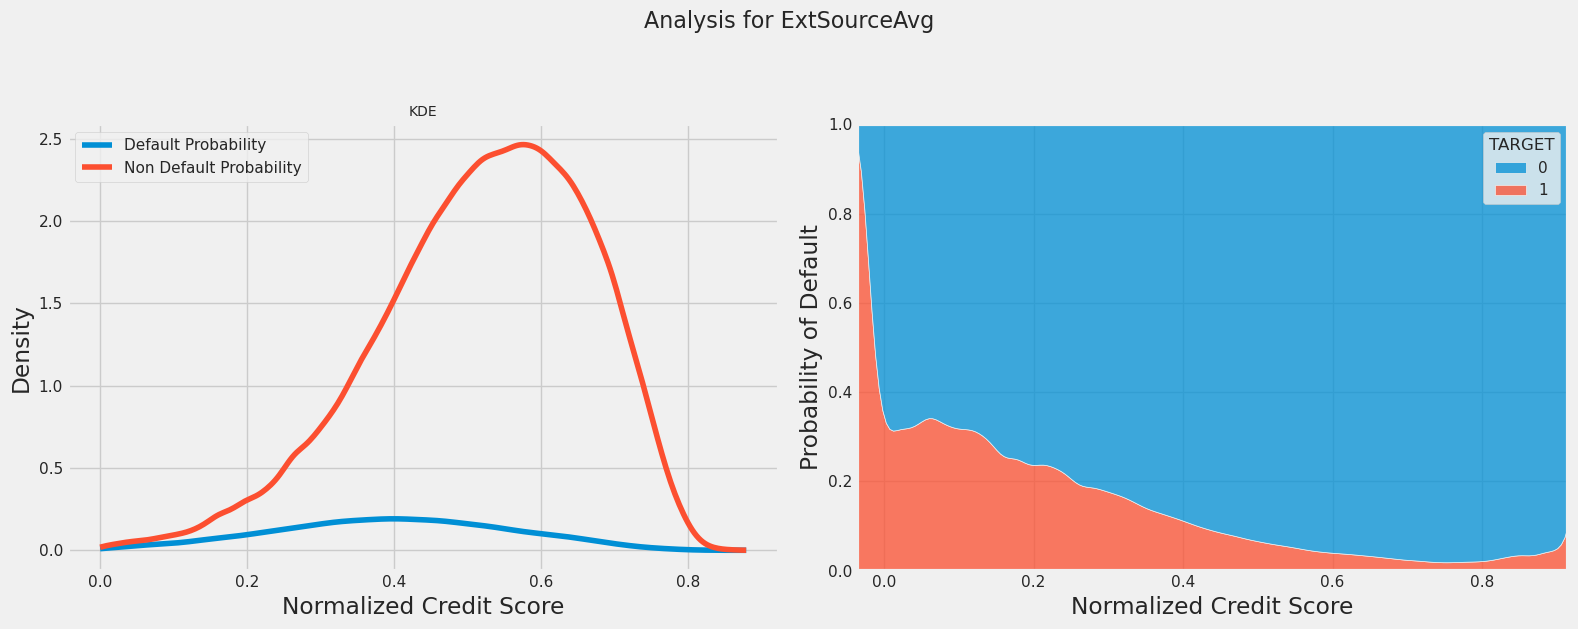

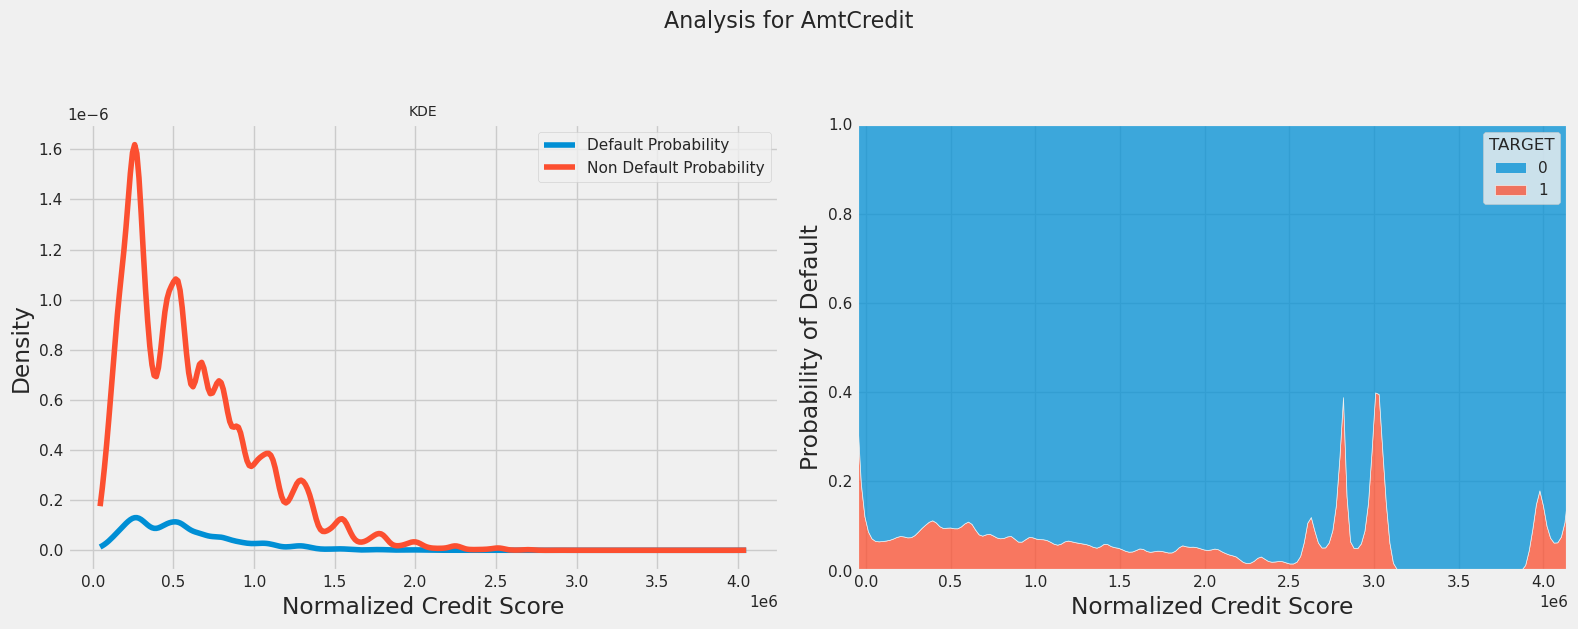

In [35]:
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

df = features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3', "TARGET", "AmtCredit"]].copy()

# Calculate the average of all ExtSources
df['ExtSourceAvg'] = df[['ExtSource1', 'ExtSource2', 'ExtSource3']].mean(axis=1, skipna=True)

# sources = ['ExtSource1']#, 'ExtSource2', 'ExtSource3', 'ExtSourceAvg']
sources = ['ExtSource1', 'ExtSource2', 'ExtSource3', 'ExtSourceAvg', 'AmtCredit']

for source in sources:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Analysis for {source}', fontsize=16, y=1.05)  # Top-level title

    # Separate the data
    subset_default = df[df['TARGET'] == 1][source].dropna()
    subset_non_default = df[df['TARGET'] == 0][source].dropna()

    # Total number of observations with valid data
    total_count = len(df[source].dropna())

    # Define the range for the KDE
    score_range = np.linspace(df[source].min(), df[source].max(), 300)

    # KDE for defaults
    kde_default = gaussian_kde(subset_default, bw_method='silverman')
    density_default = kde_default(score_range) * len(subset_default) / total_count

    # KDE for non-defaults
    kde_non_default = gaussian_kde(subset_non_default, bw_method='silverman')
    density_non_default = kde_non_default(score_range) * len(subset_non_default) / total_count

    # Plotting
    # TODO: add fill with alpha like kde plots
    sns.lineplot(x=score_range, y=density_default, ax=ax1, label='Default Probability')
    sns.lineplot(x=score_range, y=density_non_default, ax=ax1, label='Non Default Probability')

    ax1.set_title(f'KDE', fontsize=10)  # Smaller font size for subplot title
    ax1.set_xlabel('Normalized Credit Score')
    ax1.set_ylabel('Density')
    ax1.legend()

    # Regression Plot
    subset = df[[source, 'TARGET']].dropna()

    sns.kdeplot(
        data=subset,
        x=source,
        hue="TARGET",
        # kind="kde",
        # height=6,
        multiple="fill",
        ax=ax2
        # clip=(10, 80),
    )
    # plt.title("Default Rate and EXT_SOURCE_1", x=0.5, y=1.025, fontdict={"size": 16})

    ax2.set_xlabel('Normalized Credit Score')
    ax2.set_ylabel('Probability of Default')
    # ax2.legend()

    # ROC AUC as annotation
    # roc_auc = roc_auc_score(y, model.predict(X))
    # ax2.annotate(f'ROC AUC: {roc_auc:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()


In [36]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

All Accepted        190370
> 25% Rejected       66215
< 25% Rejected       34079
No Previous App.     16847
Name: PrevRatioRejectedAccepted_cats, dtype: int64

In [37]:
features_matrix_with_bins["TotalDefaults_cats"].value_counts()


No Defaults          304114
1 Defaulted Loans      3397
Name: TotalDefaults_cats, dtype: int64

In [38]:
features_matrix_with_bins["TotalDefaults"].value_counts()

KeyError: 'TotalDefaults'

In [ ]:
features_matrix["PrevRatioRejectedAccepted"].describe()

### Previous Loan History and Default Risk

The chart below shows the default rate based on whether applicant has previous applied for loans with Home Cred:
`No Previous App.` - no previous applications for client found (i.e. new clients)
`All Accepted` - all previous applications were accepted
`< 25% Rejected` - less than 1/4 applications were rejected
`> 25% Rejected` - more than 1/4 applications were rejected

In [ ]:
features_matrix_with_bins["TotalDefaults_cats"].value_counts()

In [ ]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

Interestingly we can see that while applicants whose previous loans were rejected are significantly more likely to default when finally given a loan previous clients with no failed applications have a higher default risk than new clients.

This likely limits the usefulness of the `previous_application` table because only a small proportion of clients have previously rejected applications

In [ ]:
features_matrix["TotalDefaults"].describe()

In [ ]:
list(features_matrix_with_bins.columns)

In [ ]:
shared_utils.ANY_IMP_FEATURES

In [ ]:
graph.boxen_plots_by_category(
    source_df=features_matrix_with_bins,
    group_col="pass__purpose",
    target_col="pass__loan_amnt",
    title="Loan Amount by Purpose",
    x_label="Loan Amount",
)


In [ ]:
importlib.reload(graph)
for target_y in ["AmtCredit"]:
    for c in ["CodeGender", "DaysEmployed_binned", "NameEducationType", "OccupationType", "OwnCarAge_binned",
              "DaysBirth_binned", "NameFamilyStatus"
        , "NameFamilyStatus"]:
        # for c in features_matrix_with_bins.columns:
        #     if pd.api.types.is_numeric_dtype(features_matrix_with_bins[c]):
        #         continue
        #     
        #     for 
        display(graph.boxen_plot_by_cat(c, features_matrix_with_bins, target_y, drop_small_cats=True))
